# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
rewards = env_info.rewards                         # get reward (for each agent)
dones = env_info.local_done                        # see if episode finished
scores += env_info.rewards
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the two agents looks like:', states)
print('rewards', rewards)
print('Dones', dones)
print('scores', scores)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -7.0517621  -1.5        -0.          0.
 -7.11741829  5.91759634 -0.          0.        ]
The state for the two agents looks like: [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -7.0517621  -1.5        -0.          0.
  -7.11741829  5.91759634 -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -7.05968189 -1.5         0.          0.
   7.11741829  5.91759634  0.          0.        ]]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
%load_ext autoreload
%autoreload 2

# Import the required libs and functions

In [14]:
# Import all the libs we need
import random
import copy
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from collections import namedtuple, deque

from matplotlib import pyplot as plt

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definition of the Actor and Critic Nets

Important to notice:

- Centralized Critic
- Local Actor

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class ActorNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_size, output_size, seed = 2, fc1_units=256, fc2_units=256):
        """Initialize parameters and build actor model.
        Params
        ======
            input_size (int):  number of dimensions for input layer
            output_size (int): number of dimensions for output layer
            seed (int): random seed
            fc1_units (int): number of nodes in first hidden layer
            fc2_units (int): number of nodes in second hidden layer
        """
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_size)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with near zero values."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor network that maps states to actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
    
    
class CriticNetwork(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed = 2, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            input_size (int): number of dimensions for input layer
            seed (int): random seed
            fc1_units (int): number of nodes in the first hidden layer
            fc2_units (int): number of nodes in the second hidden layer
        """
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with near zero values."""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic network that maps (states, actions) pairs to Q-values."""
        xs = F.relu(self.fc1(states))
        xs1 = self.bn1(xs)
        x = torch.cat((xs1, actions), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Network(nn.Module):
    def __init__(self, input_size, fc1_units, fc2_units, output_size, actor=False):
        super(Network, self).__init__()

        """self.input_norm = nn.BatchNorm1d(input_dim)
        self.input_norm.weight.data.fill_(1)
        self.input_norm.bias.data.fill_(0)"""

        self.fc1 = nn.Linear(input_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units,output_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.actor = actor
        #self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-1e-3, 1e-3)

    def forward(self, state):
            
        if self.actor:
            # return a vector of the force
            if state.dim() == 1:
                state = torch.unsqueeze(state,0)
            x = F.relu(self.fc1(state))
            x = self.bn1(x)
            x = F.relu(self.fc2(x))
            x = F.tanh(self.fc3(x))
            return x
        
        else:
            # critic network simply outputs a number
            #xs = torch.cat((states, actions), dim=1)
            x = F.relu(self.fc1(state))
            x = self.bn1(x)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed = 2, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        random.seed(seed)
        np.random.seed(seed)
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state



In [9]:
class DDPGAgent:

    def __init__(self, network_model, in_actor, fc1_actor, fc2_actor, out_actor, in_critic, fc1_critic, fc2_critic, lr_actor=1.0e-3, lr_critic=1.0e-3):

        super(DDPGAgent, self).__init__()
        # check if cat after fc1 is better or not ???
        if (network_model == 0):
            self.actor = Network(in_actor, fc1_actor, fc2_actor, out_actor, actor=True).to(device)
            self.critic = Network(in_critic, fc1_critic, fc2_critic, 1).to(device)
            self.target_actor = Network(in_actor, fc1_actor, fc2_actor, out_actor, actor=True).to(device)
            self.target_critic = Network(in_critic, fc1_critic, fc2_critic, 1).to(device)
        else :
            self.actor = ActorNetwork(in_actor, out_actor).to(device)
            self.critic = CriticNetwork(2*in_actor, 2*out_actor).to(device)
            self.target_actor = ActorNetwork(in_actor, out_actor).to(device)
            self.target_critic = CriticNetwork(2*in_actor, 2*out_actor).to(device)
        
        self.network_model = network_model
        
        self.noise = OUNoise(out_actor)

        # initialize targets same as original networks
        self.hard_update(self.target_actor, self.actor)
        self.hard_update(self.target_critic, self.critic)

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr_critic, weight_decay=0.00001)
        
    def hard_update(self, target, source):
        """
        Copy network parameters from source to target
        Inputs:
            target (torch.nn.Module): Net to copy parameters to
            source (torch.nn.Module): Net whose parameters to copy
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def target_act(self, state,noise=0.0):
        state = state.to(device)
        action = self.target_actor(state).cpu().data.numpy()
        action += noise*self.noise.sample()
        return np.clip(action, -1, 1)
    
    def act(self, state, noise=0.0):
        # List to tensor
        state = torch.from_numpy(state).float().to(device)
        
        # calculate action values
        self.actor.eval()
        
        #with torch.no_grad():
        action = self.actor(state).cpu().data.numpy()
        
        self.actor.train()
        
        action += noise*self.noise.sample()
            
        return np.clip(action, -1, 1)



# Definition of MADDPG

In [10]:
class MADDPG:
    def __init__(self, network_model, state=24, action=2, fc1= 256, fc2 = 256, nb_agents=2, discount_factor=0.99, tau=0.02):
        
        super(MADDPG, self).__init__()
        
        # in_actor, hidden_in_actor, hidden_out_actor, out_actor, in_critic, hidden_in_critic, hidden_out_critic
        
        #in_actor, fc1_actor, fc2_actor, out_actor, in_critic, fc1_critic, fc2_critic
        self.maddpg_agent = [DDPGAgent(network_model, state, fc1, fc2, action, 2*(state+action), fc1, fc2), 
                             DDPGAgent(network_model,state, fc1, fc2, action, 2*(state+action), fc1, fc2)]
        
        self.discount_factor = discount_factor
        self.tau = tau
        self.iter = 0  
        self.network_model = network_model

    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [ddpg_agent.target_actor for ddpg_agent in self.maddpg_agent]
        return target_actors


    def act(self, states_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        
        all_actions=[]
        
        for agent, state in zip(self.maddpg_agent, states_all_agents):
            action = agent.act(state, noise)
            all_actions.append(action)
        
        return np.array(all_actions).reshape(1, -1) # reshape 2x2 into 1x4 dim vector

    def update(self, agent_number, samples, noise):
        """update the critics and actors of all the agents """
        
        # store all next actions processed by the relevant target actor (including noise)
        all_next_actions = []
        
        # store all actions processed by the relevant actor 
        all_actions = []
        
        # Here is the tough job :  update each network
        # Here we have torch variables already
        states, actions, rewards, next_states, dones = samples
        
        # some preprocessing in order to re-arrange the data to be batch_sizexstate_dim
        for agent_id in range(2): 
            # get the torch tensor
            torch_agent_id = torch.tensor([agent_id]).to(device)
            # extract agent i's state and get action via actor network
            state = states.reshape(-1, 2, 24).index_select(1, torch_agent_id).squeeze(1)
            action = self.maddpg_agent[agent_id].actor(state)
            all_actions.append(action)    
            # extract agent i's next state and get action via target actor network
            next_state = next_states.reshape(-1, 2, 24).index_select(1, torch_agent_id).squeeze(1)
            next_action = self.maddpg_agent[agent_id].target_act(next_state)
            all_next_actions.append(next_action)
            if debugMADDPG == 1 :
                print("---- state", state)
                print("action", action)
                print("---- next_state", next_state)
                print("next_action:", next_action)
             
        agent = self.maddpg_agent[agent_number]
        
        agent.critic_optimizer.zero_grad()
        
        
        # -----------------------  Start with the Critic ------------------------------
        
      
        tmp = torch.from_numpy(np.array(all_next_actions)).float().to(device)
        all_next_actions_ = torch.cat((tmp[0], tmp[1]), dim=1)
        
        # check content
        if debugMADDPG == 1:
            print("all_actions", all_actions)
            print("all_next_actions_", all_next_actions)
            print("all_next_actions_", all_next_actions_)
            print("all_next_actions_ shape", all_next_actions_.shape)
            print("next_states", next_states.shape)
        
        if self.network_model == 0:
            target_critic_input = torch.cat((next_states, all_next_actions_), dim=1).to(device)
            with torch.no_grad():
                q_target_next = agent.target_critic(target_critic_input)
            if debugMADDPG == 1:
                print("target_critic_input", target_critic_input)
                print("target_critic_input shape", target_critic_input.shape)
        else:
            with torch.no_grad():
                q_target_next = agent.target_critic(next_states, all_next_actions_)
                
        agent_id = torch.tensor([agent_number]).to(device)
       
        if debugMADDPG == 1:
            print("q_target_next", q_target_next)
            print("rewards", rewards)
            tt = rewards.index_select(1, agent_id)
            print("rewards for this agent", tt)    
            tt2 = dones.index_select(1, agent_id)
            print("dones for this agent", tt)
            
        q_target = rewards.index_select(1, agent_id) + (self.discount_factor * q_target_next * (1 - dones.index_select(1, agent_id)))
        
        if debugMADDPG == 1:
            print("q_target", q_target)
        
        if self.network_model == 0:
            critic_input = torch.cat((states, actions), dim=1).to(device)
            q_expected = agent.critic(critic_input)
            if debugMADDPG == 1:
                print("critic input", critic_input)
                print("shape", critic_input.shape)
        else:
            q_expected = agent.critic(states, actions)
            
        if debugMADDPG == 1:
            print("q_expected", q_expected)
            
        #huber_loss = torch.nn.SmoothL1Loss()
        
        critic_loss = F.mse_loss(q_expected, q_target.detach())
        
        critic_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.7)
        
        agent.critic_optimizer.step()
        
        running_critic_loss[agent_number] += critic_loss.item()
    
        # --------------------------------Local Actor ------------------------------
        # Question: in which way the actor is local because it is fed with its own

        #update actor network using policy gradient
        agent.actor_optimizer.zero_grad()
        
        #Actions have been processed before - just detach if needed
        q_input = [ actions if i == agent_number else actions.detach() for i, actions in enumerate(all_actions) ]
        
        q_input_ = torch.cat(q_input, dim=1)
        
        if debugMADDPG == 1:
            print("q_input", q_input)
            print("q_input_", q_input_.shape)
            print("q_input_", q_input_)
        
        # combine all the actions and observations for input to critic
        # many of the obs are redundant, and obs[1] contains all useful information already
        if self.network_model == 0:
            q_input2 = torch.cat((states, q_input_), dim=1)
            actor_loss = -agent.critic(q_input2).mean()
            if debugMADDPG == 1:
                print("q2_input shape", q_input2.shape)
        else:
            actor_loss = -agent.critic(states, q_input_).mean()
     
   
        # get the policy gradient     
        actor_loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.7)
        
        agent.actor_optimizer.step()
        
        #print("running actor loss",running_actor_loss[agent_number], " item", actor_loss.item())
        running_actor_loss[agent_number] += actor_loss.item()
        #print("running actor loss after",running_actor_loss[agent_number])
        
    def update_targets(self):
        """soft update targets"""
        for ddpg_agent in self.maddpg_agent:
            self.soft_update(ddpg_agent.actor, ddpg_agent.target_actor,  self.tau)
            self.soft_update(ddpg_agent.critic, ddpg_agent.target_critic,  self.tau)
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def save_agents(self):
        # save models for local actor and critic of each agent
        i = 0;
        for ddpg_agent in self.maddpg_agent:
            torch.save(ddpg_agent.actor.state_dict(),  f"checkpoint_actor_agent_{i}.pth")
            torch.save(ddpg_agent.critic.state_dict(), f"checkpoint_critic_agent_{i}.pth")
            i+=1


In [11]:
class ReplayBuffer():
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed = 2):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): Random seed
        """
        random.seed(seed)
        np.random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [12]:
# Different way to reduce noice over time
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 3000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

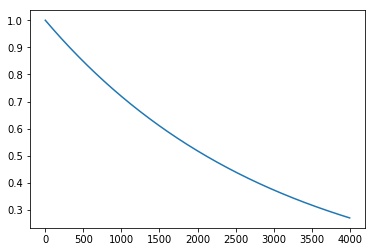

In [61]:
plt.plot([epsilon_by_frame(i) for i in range(4000)])

In [21]:
# Another one 
noise = 0.5
noise_reduction = 0.9995
noise_table = []
for i in range (30000):
    noise *= noise_reduction
    noise_table.append(noise)

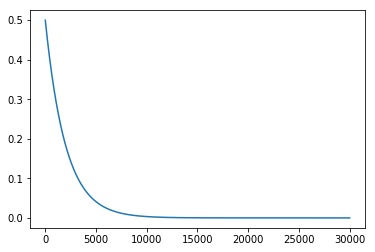

In [22]:
plt.plot(noise_table)

In [12]:
n_episodes = 3500 #5000
max_t = 1000
debugMADDPG = 0
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []
update_every_n_episodes = 2
batchsize = 396 #512
# how many episodes to save policy and gif
# amplitude of OU noise
# this slowly decreases to 0
noise = 0.68
noise_reduction = 0.999
seed = 2
inc = 0
threshold = 50000
maddpg = MADDPG(0)

# variables to store the losses and check if there is gradient explosion
running_actor_loss = [0, 0]
running_critic_loss = [0, 0]
average_actor_loss_over_time = [0, 0]
average_critic_loss_over_time = [0, 0]
loss_over_time_actor0 = []
loss_over_time_actor1 = []
loss_over_time_critic0 = []
loss_over_time_critic1 = []

replay_buffer = ReplayBuffer(100000, batchsize)

for i_episode in range(1, n_episodes+1):
    
    # Reset
    rewards = []
    env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    running_actor_loss[0] = 0
    running_actor_loss[1] = 0
    running_critic_loss[0] = 0
    running_critic_loss[1] = 0

    # loop over steps - Collect data
    for t in range(max_t):
        
        # select actions for the two agents
        action = maddpg.act(state, noise=noise)
        
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        
        # reshape some information for further processing - see report for more details about the
        # implementation (np.vstack is flattenning the list)
        all_states = state.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        all_next_states = next_state.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        
        replay_buffer.add(all_states, action, reward, all_next_states, done)
        # it is not called regulalry from what I can see in the resuls (below)
        if len(replay_buffer) > batchsize and inc % update_every_n_episodes == 0:
            for agent_inc in range(2):
                samples = replay_buffer.sample()
                maddpg.update(agent_inc, samples, noise = noise)
            maddpg.update_targets() 
            # Save loss values for further study
            if t % 20 == 0:
                for agent_inc in range(2):
                    average_actor_loss_over_time[agent_inc] += running_actor_loss[agent_inc]/20
                    average_critic_loss_over_time[agent_inc] += running_critic_loss[agent_inc]/20
                loss_over_time_actor0.append(average_actor_loss_over_time[0])
                loss_over_time_actor1.append(average_actor_loss_over_time[1])
                loss_over_time_critic0.append(average_critic_loss_over_time[0])
                loss_over_time_critic1.append(average_critic_loss_over_time[1])
                print('\rEpoch: {} \t Avg. Loss A/C0: {:4f}, {:4f} \t Avg. Loss A/C1 {:4f}, {:4f} '.format(i_episode, running_actor_loss[0]/20, running_critic_loss[0]/20,running_actor_loss[1]/20, running_critic_loss[1]/20))
                running_actor_loss[0] = 0
                running_actor_loss[1] = 0
                running_critic_loss[0] = 0
                running_critic_loss[1] = 0
            
            
        state = next_state
        
        rewards.append(reward)
        
        inc+=1
        
        if any(done):
            break

            # update - need to adjust probably the frequency for learning
    
            
    # keep noise multiplier constant until a gien threshold - then decrease it
    if inc > threshold:
        noise *= noise_reduction
    
            
    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}\tInc {}'.format(i_episode, current_avg_score, inc),end="")
    
    # log average score every 200 episodes
    if i_episode % 20 == 0:
        print('\nEpisode {}\tAverage Score: {:.3f}\tNoise reduc. {:.3f}'.format(i_episode, current_avg_score, noise))
        maddpg.save_agents()

    # break and report success if environment is solved (well actually it will never be solved!!!!!!)
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        maddpg.save_agents()
        break

Episode 20	Average Score: 0.010	Inc 384
Episode 20	Average Score: 0.010	Noise reduc. 0.680
Epoch: 22 	 Avg. Loss A/C0: 0.005876, 0.001123 	 Avg. Loss A/C1 -0.000455, 0.001152 
Epoch: 30 	 Avg. Loss A/C0: 0.005320, 0.000043 	 Avg. Loss A/C1 -0.000258, 0.000024 
Epoch: 36 	 Avg. Loss A/C0: 0.004269, 0.000015 	 Avg. Loss A/C1 -0.000374, 0.000014 
Epoch: 37 	 Avg. Loss A/C0: 0.004028, 0.000014 	 Avg. Loss A/C1 -0.000341, 0.000018 
Epoch: 40 	 Avg. Loss A/C0: 0.004143, 0.000020 	 Avg. Loss A/C1 -0.000313, 0.000017 
Episode 40	Average Score: 0.008	Inc 696
Episode 40	Average Score: 0.008	Noise reduc. 0.680
Epoch: 41 	 Avg. Loss A/C0: 0.004058, 0.000015 	 Avg. Loss A/C1 -0.000311, 0.000015 
Epoch: 42 	 Avg. Loss A/C0: 0.004051, 0.000015 	 Avg. Loss A/C1 -0.000228, 0.000010 
Epoch: 47 	 Avg. Loss A/C0: 0.003611, 0.000010 	 Avg. Loss A/C1 -0.000348, 0.000013 
Epoch: 48 	 Avg. Loss A/C0: 0.003521, 0.000011 	 Avg. Loss A/C1 -0.000356, 0.000011 
Epoch: 48 	 Avg. Loss A/C0: 0.035263, 0.000099 	 Avg.

Epoch: 156 	 Avg. Loss A/C0: -0.000509, 0.000034 	 Avg. Loss A/C1 -0.004985, 0.000044 
Epoch: 157 	 Avg. Loss A/C0: -0.000115, 0.000003 	 Avg. Loss A/C1 -0.000541, 0.000004 
Epoch: 158 	 Avg. Loss A/C0: -0.000030, 0.000004 	 Avg. Loss A/C1 -0.000510, 0.000004 
Epoch: 159 	 Avg. Loss A/C0: -0.000073, 0.000003 	 Avg. Loss A/C1 -0.000388, 0.000004 
Episode 160	Average Score: 0.032	Inc 3339
Episode 160	Average Score: 0.032	Noise reduc. 0.680
Epoch: 162 	 Avg. Loss A/C0: -0.000092, 0.000003 	 Avg. Loss A/C1 -0.000488, 0.000002 
Epoch: 162 	 Avg. Loss A/C0: -0.000849, 0.000034 	 Avg. Loss A/C1 -0.005422, 0.000037 
Epoch: 167 	 Avg. Loss A/C0: -0.000206, 0.000003 	 Avg. Loss A/C1 -0.000451, 0.000004 
Epoch: 168 	 Avg. Loss A/C0: -0.000179, 0.000002 	 Avg. Loss A/C1 -0.000597, 0.000003 
Epoch: 168 	 Avg. Loss A/C0: -0.001878, 0.000034 	 Avg. Loss A/C1 -0.005762, 0.000039 
Epoch: 174 	 Avg. Loss A/C0: -0.000364, 0.000004 	 Avg. Loss A/C1 -0.000639, 0.000003 
Epoch: 174 	 Avg. Loss A/C0: -0.0027

Epoch: 267 	 Avg. Loss A/C0: -0.000756, 0.000004 	 Avg. Loss A/C1 -0.000726, 0.000005 
Epoch: 267 	 Avg. Loss A/C0: -0.007201, 0.000035 	 Avg. Loss A/C1 -0.007535, 0.000046 
Epoch: 268 	 Avg. Loss A/C0: -0.000701, 0.000005 	 Avg. Loss A/C1 -0.000774, 0.000005 
Epoch: 269 	 Avg. Loss A/C0: -0.000628, 0.000004 	 Avg. Loss A/C1 -0.000804, 0.000004 
Epoch: 269 	 Avg. Loss A/C0: -0.007131, 0.000039 	 Avg. Loss A/C1 -0.007671, 0.000046 
Epoch: 270 	 Avg. Loss A/C0: -0.000804, 0.000005 	 Avg. Loss A/C1 -0.000748, 0.000006 
Epoch: 271 	 Avg. Loss A/C0: -0.000881, 0.000004 	 Avg. Loss A/C1 -0.000751, 0.000005 
Epoch: 272 	 Avg. Loss A/C0: -0.000760, 0.000004 	 Avg. Loss A/C1 -0.000797, 0.000005 
Epoch: 272 	 Avg. Loss A/C0: -0.007411, 0.000041 	 Avg. Loss A/C1 -0.007181, 0.000043 
Epoch: 275 	 Avg. Loss A/C0: -0.000612, 0.000004 	 Avg. Loss A/C1 -0.000791, 0.000005 
Epoch: 276 	 Avg. Loss A/C0: -0.000647, 0.000004 	 Avg. Loss A/C1 -0.000814, 0.000004 
Epoch: 276 	 Avg. Loss A/C0: -0.007636, 0.0

Epoch: 373 	 Avg. Loss A/C0: -0.011598, 0.000043 	 Avg. Loss A/C1 -0.014152, 0.000049 
Epoch: 374 	 Avg. Loss A/C0: -0.001265, 0.000005 	 Avg. Loss A/C1 -0.001270, 0.000006 
Epoch: 374 	 Avg. Loss A/C0: -0.011610, 0.000044 	 Avg. Loss A/C1 -0.014276, 0.000041 
Epoch: 375 	 Avg. Loss A/C0: -0.001190, 0.000003 	 Avg. Loss A/C1 -0.001507, 0.000005 
Epoch: 376 	 Avg. Loss A/C0: -0.001196, 0.000006 	 Avg. Loss A/C1 -0.001384, 0.000005 
Epoch: 376 	 Avg. Loss A/C0: -0.011483, 0.000051 	 Avg. Loss A/C1 -0.014072, 0.000045 
Epoch: 380 	 Avg. Loss A/C0: -0.001234, 0.000006 	 Avg. Loss A/C1 -0.001461, 0.000005 
Epoch: 380 	 Avg. Loss A/C0: -0.012147, 0.000046 	 Avg. Loss A/C1 -0.014263, 0.000043 
Epoch: 380 	 Avg. Loss A/C0: -0.012075, 0.000045 	 Avg. Loss A/C1 -0.014374, 0.000049 
Epoch: 380 	 Avg. Loss A/C0: -0.012369, 0.000046 	 Avg. Loss A/C1 -0.014174, 0.000046 
Epoch: 380 	 Avg. Loss A/C0: -0.012329, 0.000044 	 Avg. Loss A/C1 -0.014195, 0.000049 
Epoch: 380 	 Avg. Loss A/C0: -0.012141, 0.0

Epoch: 425 	 Avg. Loss A/C0: -0.017303, 0.000055 	 Avg. Loss A/C1 -0.018536, 0.000044 
Epoch: 425 	 Avg. Loss A/C0: -0.017031, 0.000055 	 Avg. Loss A/C1 -0.018263, 0.000046 
Epoch: 425 	 Avg. Loss A/C0: -0.016984, 0.000055 	 Avg. Loss A/C1 -0.018198, 0.000045 
Epoch: 425 	 Avg. Loss A/C0: -0.016742, 0.000051 	 Avg. Loss A/C1 -0.018273, 0.000040 
Epoch: 425 	 Avg. Loss A/C0: -0.017462, 0.000057 	 Avg. Loss A/C1 -0.018236, 0.000047 
Epoch: 425 	 Avg. Loss A/C0: -0.017042, 0.000055 	 Avg. Loss A/C1 -0.018318, 0.000047 
Epoch: 426 	 Avg. Loss A/C0: -0.001570, 0.000004 	 Avg. Loss A/C1 -0.001962, 0.000006 
Epoch: 426 	 Avg. Loss A/C0: -0.017379, 0.000056 	 Avg. Loss A/C1 -0.018505, 0.000048 
Epoch: 426 	 Avg. Loss A/C0: -0.016961, 0.000059 	 Avg. Loss A/C1 -0.018630, 0.000052 
Epoch: 426 	 Avg. Loss A/C0: -0.017411, 0.000065 	 Avg. Loss A/C1 -0.018071, 0.000047 
Epoch: 427 	 Avg. Loss A/C0: -0.001696, 0.000007 	 Avg. Loss A/C1 -0.001655, 0.000004 
Epoch: 427 	 Avg. Loss A/C0: -0.017245, 0.0

Epoch: 487 	 Avg. Loss A/C0: -0.028731, 0.000064 	 Avg. Loss A/C1 -0.029129, 0.000063 
Epoch: 490 	 Avg. Loss A/C0: -0.002919, 0.000005 	 Avg. Loss A/C1 -0.002768, 0.000005 
Epoch: 491 	 Avg. Loss A/C0: -0.002969, 0.000007 	 Avg. Loss A/C1 -0.002758, 0.000005 
Epoch: 491 	 Avg. Loss A/C0: -0.030436, 0.000069 	 Avg. Loss A/C1 -0.029898, 0.000059 
Epoch: 491 	 Avg. Loss A/C0: -0.030210, 0.000073 	 Avg. Loss A/C1 -0.030407, 0.000065 
Epoch: 491 	 Avg. Loss A/C0: -0.030152, 0.000070 	 Avg. Loss A/C1 -0.029805, 0.000064 
Epoch: 491 	 Avg. Loss A/C0: -0.030924, 0.000077 	 Avg. Loss A/C1 -0.030799, 0.000056 
Epoch: 491 	 Avg. Loss A/C0: -0.030746, 0.000065 	 Avg. Loss A/C1 -0.031189, 0.000067 
Epoch: 491 	 Avg. Loss A/C0: -0.030546, 0.000069 	 Avg. Loss A/C1 -0.029811, 0.000059 
Epoch: 491 	 Avg. Loss A/C0: -0.030130, 0.000062 	 Avg. Loss A/C1 -0.030888, 0.000066 
Epoch: 491 	 Avg. Loss A/C0: -0.031005, 0.000068 	 Avg. Loss A/C1 -0.030263, 0.000058 
Epoch: 491 	 Avg. Loss A/C0: -0.030324, 0.0

Epoch: 508 	 Avg. Loss A/C0: -0.004637, 0.000011 	 Avg. Loss A/C1 -0.004088, 0.000008 
Epoch: 508 	 Avg. Loss A/C0: -0.043699, 0.000080 	 Avg. Loss A/C1 -0.041697, 0.000080 
Epoch: 508 	 Avg. Loss A/C0: -0.043489, 0.000088 	 Avg. Loss A/C1 -0.041506, 0.000072 
Epoch: 508 	 Avg. Loss A/C0: -0.043898, 0.000079 	 Avg. Loss A/C1 -0.040762, 0.000073 
Epoch: 508 	 Avg. Loss A/C0: -0.044597, 0.000078 	 Avg. Loss A/C1 -0.040651, 0.000073 
Epoch: 508 	 Avg. Loss A/C0: -0.044127, 0.000091 	 Avg. Loss A/C1 -0.040817, 0.000073 
Epoch: 508 	 Avg. Loss A/C0: -0.043859, 0.000085 	 Avg. Loss A/C1 -0.042134, 0.000074 
Epoch: 508 	 Avg. Loss A/C0: -0.044803, 0.000095 	 Avg. Loss A/C1 -0.041877, 0.000082 
Epoch: 508 	 Avg. Loss A/C0: -0.044809, 0.000089 	 Avg. Loss A/C1 -0.041432, 0.000080 
Epoch: 508 	 Avg. Loss A/C0: -0.045310, 0.000098 	 Avg. Loss A/C1 -0.042640, 0.000069 
Epoch: 508 	 Avg. Loss A/C0: -0.044622, 0.000099 	 Avg. Loss A/C1 -0.042172, 0.000072 
Epoch: 508 	 Avg. Loss A/C0: -0.044608, 0.0

Epoch: 513 	 Avg. Loss A/C0: -0.055596, 0.000106 	 Avg. Loss A/C1 -0.050383, 0.000098 
Epoch: 513 	 Avg. Loss A/C0: -0.055110, 0.000122 	 Avg. Loss A/C1 -0.051726, 0.000091 
Epoch: 513 	 Avg. Loss A/C0: -0.055807, 0.000110 	 Avg. Loss A/C1 -0.051153, 0.000089 
Epoch: 513 	 Avg. Loss A/C0: -0.055450, 0.000110 	 Avg. Loss A/C1 -0.051588, 0.000095 
Epoch: 515 	 Avg. Loss A/C0: -0.005519, 0.000011 	 Avg. Loss A/C1 -0.005186, 0.000010 
Epoch: 515 	 Avg. Loss A/C0: -0.056377, 0.000099 	 Avg. Loss A/C1 -0.051135, 0.000091 
Epoch: 515 	 Avg. Loss A/C0: -0.057248, 0.000109 	 Avg. Loss A/C1 -0.052689, 0.000101 
Epoch: 516 	 Avg. Loss A/C0: -0.005771, 0.000011 	 Avg. Loss A/C1 -0.005222, 0.000013 
Epoch: 516 	 Avg. Loss A/C0: -0.056988, 0.000109 	 Avg. Loss A/C1 -0.051203, 0.000090 
Epoch: 516 	 Avg. Loss A/C0: -0.056023, 0.000101 	 Avg. Loss A/C1 -0.052680, 0.000098 
Epoch: 519 	 Avg. Loss A/C0: -0.005741, 0.000013 	 Avg. Loss A/C1 -0.005434, 0.000007 
Epoch: 519 	 Avg. Loss A/C0: -0.057366, 0.0

Epoch: 541 	 Avg. Loss A/C0: -0.081140, 0.000138 	 Avg. Loss A/C1 -0.074918, 0.000144 
Epoch: 541 	 Avg. Loss A/C0: -0.081370, 0.000146 	 Avg. Loss A/C1 -0.073969, 0.000132 
Epoch: 542 	 Avg. Loss A/C0: -0.008250, 0.000017 	 Avg. Loss A/C1 -0.007340, 0.000009 
Epoch: 542 	 Avg. Loss A/C0: -0.080735, 0.000140 	 Avg. Loss A/C1 -0.074932, 0.000132 
Epoch: 542 	 Avg. Loss A/C0: -0.081833, 0.000140 	 Avg. Loss A/C1 -0.074310, 0.000126 
Epoch: 542 	 Avg. Loss A/C0: -0.081484, 0.000139 	 Avg. Loss A/C1 -0.075244, 0.000149 
Epoch: 542 	 Avg. Loss A/C0: -0.081777, 0.000146 	 Avg. Loss A/C1 -0.074097, 0.000146 
Epoch: 542 	 Avg. Loss A/C0: -0.082847, 0.000139 	 Avg. Loss A/C1 -0.074668, 0.000125 
Epoch: 542 	 Avg. Loss A/C0: -0.082095, 0.000131 	 Avg. Loss A/C1 -0.075360, 0.000130 
Epoch: 542 	 Avg. Loss A/C0: -0.082036, 0.000119 	 Avg. Loss A/C1 -0.075681, 0.000140 
Epoch: 542 	 Avg. Loss A/C0: -0.082714, 0.000138 	 Avg. Loss A/C1 -0.074499, 0.000119 
Epoch: 542 	 Avg. Loss A/C0: -0.082036, 0.0

Epoch: 573 	 Avg. Loss A/C0: -0.093079, 0.000152 	 Avg. Loss A/C1 -0.088542, 0.000152 
Epoch: 573 	 Avg. Loss A/C0: -0.094409, 0.000171 	 Avg. Loss A/C1 -0.089291, 0.000150 
Epoch: 573 	 Avg. Loss A/C0: -0.093424, 0.000166 	 Avg. Loss A/C1 -0.090488, 0.000155 
Epoch: 575 	 Avg. Loss A/C0: -0.009290, 0.000012 	 Avg. Loss A/C1 -0.009215, 0.000017 
Epoch: 575 	 Avg. Loss A/C0: -0.094213, 0.000152 	 Avg. Loss A/C1 -0.088936, 0.000165 
Epoch: 575 	 Avg. Loss A/C0: -0.095374, 0.000173 	 Avg. Loss A/C1 -0.090577, 0.000171 
Epoch: 575 	 Avg. Loss A/C0: -0.094504, 0.000165 	 Avg. Loss A/C1 -0.089728, 0.000164 
Epoch: 575 	 Avg. Loss A/C0: -0.094185, 0.000190 	 Avg. Loss A/C1 -0.090386, 0.000162 
Epoch: 575 	 Avg. Loss A/C0: -0.095163, 0.000179 	 Avg. Loss A/C1 -0.091223, 0.000176 
Epoch: 575 	 Avg. Loss A/C0: -0.093993, 0.000174 	 Avg. Loss A/C1 -0.089592, 0.000181 
Epoch: 575 	 Avg. Loss A/C0: -0.094684, 0.000176 	 Avg. Loss A/C1 -0.091329, 0.000181 
Epoch: 575 	 Avg. Loss A/C0: -0.094979, 0.0

Epoch: 587 	 Avg. Loss A/C0: -0.101468, 0.000191 	 Avg. Loss A/C1 -0.098135, 0.000188 
Epoch: 587 	 Avg. Loss A/C0: -0.101985, 0.000206 	 Avg. Loss A/C1 -0.098466, 0.000165 
Epoch: 587 	 Avg. Loss A/C0: -0.101420, 0.000211 	 Avg. Loss A/C1 -0.098951, 0.000173 
Epoch: 587 	 Avg. Loss A/C0: -0.102305, 0.000195 	 Avg. Loss A/C1 -0.098646, 0.000194 
Epoch: 587 	 Avg. Loss A/C0: -0.101266, 0.000195 	 Avg. Loss A/C1 -0.098531, 0.000202 
Epoch: 587 	 Avg. Loss A/C0: -0.101346, 0.000180 	 Avg. Loss A/C1 -0.097969, 0.000181 
Epoch: 587 	 Avg. Loss A/C0: -0.102950, 0.000204 	 Avg. Loss A/C1 -0.099032, 0.000198 
Epoch: 587 	 Avg. Loss A/C0: -0.102064, 0.000200 	 Avg. Loss A/C1 -0.098295, 0.000201 
Epoch: 587 	 Avg. Loss A/C0: -0.102694, 0.000193 	 Avg. Loss A/C1 -0.100078, 0.000173 
Epoch: 590 	 Avg. Loss A/C0: -0.010363, 0.000022 	 Avg. Loss A/C1 -0.010242, 0.000017 
Epoch: 590 	 Avg. Loss A/C0: -0.102661, 0.000219 	 Avg. Loss A/C1 -0.099498, 0.000196 
Epoch: 590 	 Avg. Loss A/C0: -0.102605, 0.0

Epoch: 610 	 Avg. Loss A/C0: -0.111300, 0.000223 	 Avg. Loss A/C1 -0.111034, 0.000226 
Epoch: 613 	 Avg. Loss A/C0: -0.011195, 0.000022 	 Avg. Loss A/C1 -0.011395, 0.000030 
Epoch: 613 	 Avg. Loss A/C0: -0.112693, 0.000196 	 Avg. Loss A/C1 -0.110537, 0.000224 
Epoch: 614 	 Avg. Loss A/C0: -0.011059, 0.000020 	 Avg. Loss A/C1 -0.011168, 0.000030 
Epoch: 614 	 Avg. Loss A/C0: -0.112101, 0.000197 	 Avg. Loss A/C1 -0.110784, 0.000222 
Epoch: 615 	 Avg. Loss A/C0: -0.011153, 0.000024 	 Avg. Loss A/C1 -0.011261, 0.000029 
Epoch: 615 	 Avg. Loss A/C0: -0.112687, 0.000207 	 Avg. Loss A/C1 -0.111130, 0.000221 
Epoch: 615 	 Avg. Loss A/C0: -0.111282, 0.000206 	 Avg. Loss A/C1 -0.111600, 0.000263 
Epoch: 615 	 Avg. Loss A/C0: -0.112508, 0.000196 	 Avg. Loss A/C1 -0.110505, 0.000229 
Epoch: 617 	 Avg. Loss A/C0: -0.011274, 0.000017 	 Avg. Loss A/C1 -0.010937, 0.000024 
Epoch: 617 	 Avg. Loss A/C0: -0.112605, 0.000214 	 Avg. Loss A/C1 -0.111346, 0.000225 
Epoch: 617 	 Avg. Loss A/C0: -0.112921, 0.0

Epoch: 655 	 Avg. Loss A/C0: -0.126737, 0.000262 	 Avg. Loss A/C1 -0.126182, 0.000246 
Epoch: 655 	 Avg. Loss A/C0: -0.126616, 0.000263 	 Avg. Loss A/C1 -0.125022, 0.000261 
Epoch: 655 	 Avg. Loss A/C0: -0.127058, 0.000249 	 Avg. Loss A/C1 -0.124681, 0.000250 
Epoch: 655 	 Avg. Loss A/C0: -0.126601, 0.000229 	 Avg. Loss A/C1 -0.124642, 0.000259 
Epoch: 655 	 Avg. Loss A/C0: -0.126091, 0.000275 	 Avg. Loss A/C1 -0.125256, 0.000265 
Epoch: 655 	 Avg. Loss A/C0: -0.126771, 0.000307 	 Avg. Loss A/C1 -0.125988, 0.000253 
Epoch: 655 	 Avg. Loss A/C0: -0.126479, 0.000290 	 Avg. Loss A/C1 -0.125504, 0.000267 
Epoch: 655 	 Avg. Loss A/C0: -0.126059, 0.000280 	 Avg. Loss A/C1 -0.125326, 0.000292 
Epoch: 655 	 Avg. Loss A/C0: -0.128576, 0.000266 	 Avg. Loss A/C1 -0.125382, 0.000274 
Epoch: 655 	 Avg. Loss A/C0: -0.125860, 0.000251 	 Avg. Loss A/C1 -0.126805, 0.000256 
Epoch: 655 	 Avg. Loss A/C0: -0.127254, 0.000243 	 Avg. Loss A/C1 -0.124580, 0.000287 
Epoch: 655 	 Avg. Loss A/C0: -0.126945, 0.0

Epoch: 664 	 Avg. Loss A/C0: -0.136453, 0.000228 	 Avg. Loss A/C1 -0.134173, 0.000285 
Epoch: 664 	 Avg. Loss A/C0: -0.135288, 0.000237 	 Avg. Loss A/C1 -0.132072, 0.000284 
Epoch: 664 	 Avg. Loss A/C0: -0.136796, 0.000266 	 Avg. Loss A/C1 -0.133404, 0.000281 
Epoch: 664 	 Avg. Loss A/C0: -0.138288, 0.000227 	 Avg. Loss A/C1 -0.132739, 0.000302 
Epoch: 664 	 Avg. Loss A/C0: -0.136638, 0.000260 	 Avg. Loss A/C1 -0.132359, 0.000275 
Epoch: 664 	 Avg. Loss A/C0: -0.136756, 0.000247 	 Avg. Loss A/C1 -0.133933, 0.000247 
Epoch: 664 	 Avg. Loss A/C0: -0.137170, 0.000295 	 Avg. Loss A/C1 -0.133368, 0.000260 
Epoch: 664 	 Avg. Loss A/C0: -0.137293, 0.000249 	 Avg. Loss A/C1 -0.132374, 0.000354 
Epoch: 664 	 Avg. Loss A/C0: -0.136837, 0.000241 	 Avg. Loss A/C1 -0.132736, 0.000281 
Epoch: 665 	 Avg. Loss A/C0: -0.013838, 0.000021 	 Avg. Loss A/C1 -0.013112, 0.000029 
Epoch: 665 	 Avg. Loss A/C0: -0.137720, 0.000252 	 Avg. Loss A/C1 -0.133133, 0.000273 
Epoch: 665 	 Avg. Loss A/C0: -0.137773, 0.0

Epoch: 685 	 Avg. Loss A/C0: -0.154266, 0.000310 	 Avg. Loss A/C1 -0.149563, 0.000424 
Epoch: 685 	 Avg. Loss A/C0: -0.155038, 0.000310 	 Avg. Loss A/C1 -0.149656, 0.000326 
Epoch: 686 	 Avg. Loss A/C0: -0.015505, 0.000040 	 Avg. Loss A/C1 -0.014639, 0.000028 
Epoch: 686 	 Avg. Loss A/C0: -0.155108, 0.000342 	 Avg. Loss A/C1 -0.149800, 0.000322 
Epoch: 686 	 Avg. Loss A/C0: -0.155150, 0.000350 	 Avg. Loss A/C1 -0.149836, 0.000367 
Epoch: 686 	 Avg. Loss A/C0: -0.155875, 0.000342 	 Avg. Loss A/C1 -0.149735, 0.000312 
Epoch: 687 	 Avg. Loss A/C0: -0.015841, 0.000035 	 Avg. Loss A/C1 -0.014403, 0.000026 
Epoch: 687 	 Avg. Loss A/C0: -0.155768, 0.000309 	 Avg. Loss A/C1 -0.150411, 0.000296 
Epoch: 687 	 Avg. Loss A/C0: -0.155183, 0.000360 	 Avg. Loss A/C1 -0.149334, 0.000276 
Epoch: 687 	 Avg. Loss A/C0: -0.156027, 0.000339 	 Avg. Loss A/C1 -0.148228, 0.000308 
Epoch: 687 	 Avg. Loss A/C0: -0.156272, 0.000338 	 Avg. Loss A/C1 -0.149333, 0.000330 
Epoch: 687 	 Avg. Loss A/C0: -0.156886, 0.0

Epoch: 708 	 Avg. Loss A/C0: -0.166585, 0.000320 	 Avg. Loss A/C1 -0.153149, 0.000309 
Epoch: 708 	 Avg. Loss A/C0: -0.167457, 0.000344 	 Avg. Loss A/C1 -0.153606, 0.000364 
Epoch: 708 	 Avg. Loss A/C0: -0.166150, 0.000323 	 Avg. Loss A/C1 -0.154820, 0.000320 
Epoch: 708 	 Avg. Loss A/C0: -0.166743, 0.000300 	 Avg. Loss A/C1 -0.154311, 0.000328 
Epoch: 712 	 Avg. Loss A/C0: -0.016484, 0.000035 	 Avg. Loss A/C1 -0.015351, 0.000021 
Epoch: 712 	 Avg. Loss A/C0: -0.168046, 0.000353 	 Avg. Loss A/C1 -0.154683, 0.000341 
Epoch: 712 	 Avg. Loss A/C0: -0.168103, 0.000329 	 Avg. Loss A/C1 -0.155267, 0.000336 
Epoch: 712 	 Avg. Loss A/C0: -0.168743, 0.000324 	 Avg. Loss A/C1 -0.154656, 0.000339 
Epoch: 713 	 Avg. Loss A/C0: -0.017019, 0.000025 	 Avg. Loss A/C1 -0.015559, 0.000033 
Epoch: 713 	 Avg. Loss A/C0: -0.169061, 0.000358 	 Avg. Loss A/C1 -0.155097, 0.000337 
Epoch: 713 	 Avg. Loss A/C0: -0.167988, 0.000299 	 Avg. Loss A/C1 -0.154846, 0.000351 
Epoch: 713 	 Avg. Loss A/C0: -0.168027, 0.0

Epoch: 742 	 Avg. Loss A/C0: -0.172908, 0.000363 	 Avg. Loss A/C1 -0.158517, 0.000330 
Epoch: 742 	 Avg. Loss A/C0: -0.173855, 0.000403 	 Avg. Loss A/C1 -0.158415, 0.000365 
Epoch: 742 	 Avg. Loss A/C0: -0.174280, 0.000388 	 Avg. Loss A/C1 -0.157404, 0.000344 
Epoch: 742 	 Avg. Loss A/C0: -0.174345, 0.000403 	 Avg. Loss A/C1 -0.159314, 0.000355 
Epoch: 742 	 Avg. Loss A/C0: -0.173412, 0.000421 	 Avg. Loss A/C1 -0.158435, 0.000316 
Epoch: 743 	 Avg. Loss A/C0: -0.017228, 0.000065 	 Avg. Loss A/C1 -0.015745, 0.000033 
Epoch: 743 	 Avg. Loss A/C0: -0.174382, 0.000405 	 Avg. Loss A/C1 -0.159553, 0.000343 
Epoch: 743 	 Avg. Loss A/C0: -0.174372, 0.000360 	 Avg. Loss A/C1 -0.158140, 0.000327 
Epoch: 746 	 Avg. Loss A/C0: -0.017425, 0.000028 	 Avg. Loss A/C1 -0.016157, 0.000027 
Epoch: 746 	 Avg. Loss A/C0: -0.174603, 0.000394 	 Avg. Loss A/C1 -0.160401, 0.000345 
Epoch: 746 	 Avg. Loss A/C0: -0.174504, 0.000374 	 Avg. Loss A/C1 -0.159442, 0.000368 
Epoch: 746 	 Avg. Loss A/C0: -0.175627, 0.0

Epoch: 767 	 Avg. Loss A/C0: -0.184005, 0.000432 	 Avg. Loss A/C1 -0.164805, 0.000390 
Epoch: 767 	 Avg. Loss A/C0: -0.185151, 0.000403 	 Avg. Loss A/C1 -0.163673, 0.000353 
Epoch: 767 	 Avg. Loss A/C0: -0.185276, 0.000418 	 Avg. Loss A/C1 -0.163183, 0.000314 
Epoch: 772 	 Avg. Loss A/C0: -0.018509, 0.000043 	 Avg. Loss A/C1 -0.016447, 0.000032 
Epoch: 772 	 Avg. Loss A/C0: -0.185451, 0.000435 	 Avg. Loss A/C1 -0.163626, 0.000370 
Epoch: 772 	 Avg. Loss A/C0: -0.185771, 0.000458 	 Avg. Loss A/C1 -0.163088, 0.000293 
Epoch: 772 	 Avg. Loss A/C0: -0.185493, 0.000418 	 Avg. Loss A/C1 -0.163955, 0.000341 
Epoch: 774 	 Avg. Loss A/C0: -0.018690, 0.000030 	 Avg. Loss A/C1 -0.016405, 0.000044 
Epoch: 774 	 Avg. Loss A/C0: -0.185923, 0.000415 	 Avg. Loss A/C1 -0.162725, 0.000355 
Epoch: 774 	 Avg. Loss A/C0: -0.186704, 0.000456 	 Avg. Loss A/C1 -0.163918, 0.000323 
Epoch: 774 	 Avg. Loss A/C0: -0.186354, 0.000455 	 Avg. Loss A/C1 -0.162802, 0.000336 
Epoch: 774 	 Avg. Loss A/C0: -0.185659, 0.0

Epoch: 787 	 Avg. Loss A/C0: -0.190048, 0.000483 	 Avg. Loss A/C1 -0.163790, 0.000330 
Epoch: 788 	 Avg. Loss A/C0: -0.019226, 0.000041 	 Avg. Loss A/C1 -0.016693, 0.000032 
Epoch: 788 	 Avg. Loss A/C0: -0.191768, 0.000457 	 Avg. Loss A/C1 -0.164250, 0.000345 
Epoch: 788 	 Avg. Loss A/C0: -0.190440, 0.000449 	 Avg. Loss A/C1 -0.163463, 0.000384 
Epoch: 788 	 Avg. Loss A/C0: -0.190361, 0.000446 	 Avg. Loss A/C1 -0.163999, 0.000345 
Epoch: 788 	 Avg. Loss A/C0: -0.190655, 0.000461 	 Avg. Loss A/C1 -0.165059, 0.000359 
Epoch: 788 	 Avg. Loss A/C0: -0.190085, 0.000467 	 Avg. Loss A/C1 -0.162594, 0.000372 
Epoch: 788 	 Avg. Loss A/C0: -0.190122, 0.000481 	 Avg. Loss A/C1 -0.163210, 0.000373 
Epoch: 788 	 Avg. Loss A/C0: -0.191903, 0.000496 	 Avg. Loss A/C1 -0.164905, 0.000362 
Epoch: 788 	 Avg. Loss A/C0: -0.190211, 0.000500 	 Avg. Loss A/C1 -0.163175, 0.000396 
Epoch: 788 	 Avg. Loss A/C0: -0.191630, 0.000454 	 Avg. Loss A/C1 -0.164396, 0.000383 
Epoch: 788 	 Avg. Loss A/C0: -0.191308, 0.0

Epoch: 803 	 Avg. Loss A/C0: -0.019542, 0.000070 	 Avg. Loss A/C1 -0.016643, 0.000034 
Epoch: 803 	 Avg. Loss A/C0: -0.190450, 0.000507 	 Avg. Loss A/C1 -0.166692, 0.000304 
Epoch: 803 	 Avg. Loss A/C0: -0.190870, 0.000477 	 Avg. Loss A/C1 -0.167166, 0.000427 
Epoch: 803 	 Avg. Loss A/C0: -0.191004, 0.000494 	 Avg. Loss A/C1 -0.167272, 0.000348 
Epoch: 808 	 Avg. Loss A/C0: -0.019067, 0.000037 	 Avg. Loss A/C1 -0.016880, 0.000035 
Epoch: 808 	 Avg. Loss A/C0: -0.189510, 0.000480 	 Avg. Loss A/C1 -0.168741, 0.000352 
Epoch: 808 	 Avg. Loss A/C0: -0.190948, 0.000527 	 Avg. Loss A/C1 -0.167130, 0.000369 
Epoch: 808 	 Avg. Loss A/C0: -0.190272, 0.000558 	 Avg. Loss A/C1 -0.167846, 0.000394 
Epoch: 808 	 Avg. Loss A/C0: -0.191059, 0.000521 	 Avg. Loss A/C1 -0.167459, 0.000294 
Epoch: 808 	 Avg. Loss A/C0: -0.189289, 0.000504 	 Avg. Loss A/C1 -0.167637, 0.000356 
Epoch: 808 	 Avg. Loss A/C0: -0.190191, 0.000446 	 Avg. Loss A/C1 -0.168188, 0.000374 
Epoch: 808 	 Avg. Loss A/C0: -0.191677, 0.0

Epoch: 819 	 Avg. Loss A/C0: -0.187452, 0.000436 	 Avg. Loss A/C1 -0.172699, 0.000383 
Epoch: 819 	 Avg. Loss A/C0: -0.187803, 0.000462 	 Avg. Loss A/C1 -0.173226, 0.000364 
Epoch: 819 	 Avg. Loss A/C0: -0.188250, 0.000407 	 Avg. Loss A/C1 -0.173151, 0.000337 
Epoch: 819 	 Avg. Loss A/C0: -0.188020, 0.000428 	 Avg. Loss A/C1 -0.173725, 0.000325 
Epoch: 819 	 Avg. Loss A/C0: -0.187750, 0.000458 	 Avg. Loss A/C1 -0.171469, 0.000320 
Episode 820	Average Score: 0.414	Inc 62822
Episode 820	Average Score: 0.414	Noise reduc. 0.631
Epoch: 821 	 Avg. Loss A/C0: -0.018598, 0.000040 	 Avg. Loss A/C1 -0.016908, 0.000038 
Epoch: 821 	 Avg. Loss A/C0: -0.187870, 0.000464 	 Avg. Loss A/C1 -0.173998, 0.000296 
Epoch: 821 	 Avg. Loss A/C0: -0.186903, 0.000463 	 Avg. Loss A/C1 -0.172604, 0.000347 
Epoch: 821 	 Avg. Loss A/C0: -0.187540, 0.000454 	 Avg. Loss A/C1 -0.174922, 0.000288 
Epoch: 821 	 Avg. Loss A/C0: -0.186133, 0.000441 	 Avg. Loss A/C1 -0.175170, 0.000342 
Epoch: 821 	 Avg. Loss A/C0: -0.187

Epoch: 835 	 Avg. Loss A/C0: -0.184757, 0.000456 	 Avg. Loss A/C1 -0.175447, 0.000355 
Epoch: 835 	 Avg. Loss A/C0: -0.185116, 0.000406 	 Avg. Loss A/C1 -0.175491, 0.000318 
Epoch: 835 	 Avg. Loss A/C0: -0.186782, 0.000447 	 Avg. Loss A/C1 -0.174826, 0.000322 
Epoch: 835 	 Avg. Loss A/C0: -0.185993, 0.000389 	 Avg. Loss A/C1 -0.175896, 0.000359 
Epoch: 835 	 Avg. Loss A/C0: -0.185077, 0.000362 	 Avg. Loss A/C1 -0.176185, 0.000367 
Episode 840	Average Score: 0.445	Inc 66626
Episode 840	Average Score: 0.445	Noise reduc. 0.618
Epoch: 841 	 Avg. Loss A/C0: -0.018091, 0.000048 	 Avg. Loss A/C1 -0.018222, 0.000046 
Epoch: 841 	 Avg. Loss A/C0: -0.185153, 0.000441 	 Avg. Loss A/C1 -0.178145, 0.000313 
Epoch: 841 	 Avg. Loss A/C0: -0.184917, 0.000431 	 Avg. Loss A/C1 -0.177850, 0.000341 
Epoch: 841 	 Avg. Loss A/C0: -0.183490, 0.000369 	 Avg. Loss A/C1 -0.177592, 0.000375 
Epoch: 841 	 Avg. Loss A/C0: -0.185202, 0.000427 	 Avg. Loss A/C1 -0.178926, 0.000329 
Epoch: 841 	 Avg. Loss A/C0: -0.183

Epoch: 853 	 Avg. Loss A/C0: -0.182539, 0.000413 	 Avg. Loss A/C1 -0.181550, 0.000362 
Epoch: 854 	 Avg. Loss A/C0: -0.018283, 0.000039 	 Avg. Loss A/C1 -0.017670, 0.000029 
Epoch: 854 	 Avg. Loss A/C0: -0.181270, 0.000372 	 Avg. Loss A/C1 -0.181424, 0.000336 
Epoch: 854 	 Avg. Loss A/C0: -0.181828, 0.000376 	 Avg. Loss A/C1 -0.180914, 0.000421 
Epoch: 854 	 Avg. Loss A/C0: -0.181791, 0.000408 	 Avg. Loss A/C1 -0.181341, 0.000353 
Epoch: 854 	 Avg. Loss A/C0: -0.182341, 0.000371 	 Avg. Loss A/C1 -0.184118, 0.000396 
Epoch: 854 	 Avg. Loss A/C0: -0.182286, 0.000393 	 Avg. Loss A/C1 -0.181538, 0.000384 
Epoch: 854 	 Avg. Loss A/C0: -0.182899, 0.000348 	 Avg. Loss A/C1 -0.181492, 0.000415 
Epoch: 854 	 Avg. Loss A/C0: -0.183878, 0.000379 	 Avg. Loss A/C1 -0.182664, 0.000341 
Epoch: 854 	 Avg. Loss A/C0: -0.182226, 0.000384 	 Avg. Loss A/C1 -0.181944, 0.000335 
Epoch: 858 	 Avg. Loss A/C0: -0.018118, 0.000039 	 Avg. Loss A/C1 -0.018689, 0.000054 
Epoch: 858 	 Avg. Loss A/C0: -0.181423, 0.0

In [ ]:
env.close()

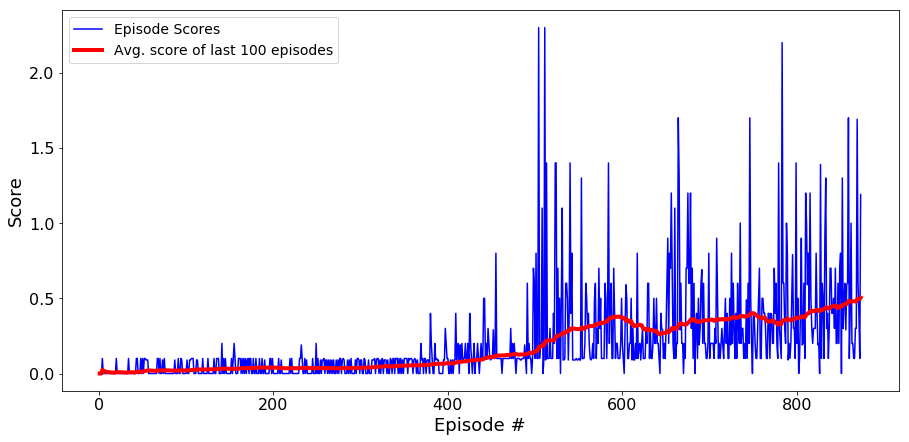

In [14]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'r',\
         linewidth=4,label='Avg. score of last 100 episodes')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.show()




In [17]:
print(scores_avg)

[0.0, 0.0, 0.0, 0.02500000037252903, 0.020000000298023225, 0.016666666915019352, 0.014285714498588018, 0.012500000186264515, 0.011111111276679568, 0.010000000149011612, 0.0090909092263741931, 0.008333333457509676, 0.0076923078069320088, 0.0071428572492940089, 0.0066666667660077415, 0.0062500000931322575, 0.0058823530288303599, 0.005555555638339784, 0.0052631579731640061, 0.010000000149011612, 0.009523809665725344, 0.0090909092263741931, 0.0086956523034883576, 0.008333333457509676, 0.0080000001192092902, 0.0076923078069320088, 0.0074074075177863793, 0.0071428572492940089, 0.0068965518269045603, 0.0066666667660077415, 0.0064516129993623305, 0.0062500000931322575, 0.0060606061509161282, 0.0088235295432455407, 0.008571428699152811, 0.008333333457509676, 0.0081081082289283339, 0.0078947369597460095, 0.0076923078069320088, 0.0075000001117587088, 0.0073170732797645938, 0.0071428572492940089, 0.0093023257200108012, 0.011363636532967741, 0.011111111276679568, 0.010869565379360447, 0.01063829803

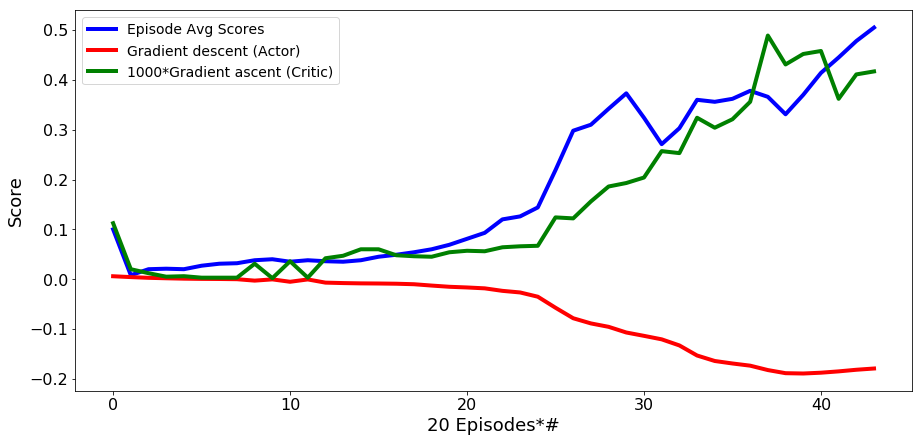

In [16]:
avg_score = [0.1, 0.008, 0.020, 0.021, 0.020, 0.027, 0.031, 0.032,  0.038, 0.040, 0.035, 0.038,0.036,0.035, 0.038,0.045,0.049,0.054,0.060,0.069,0.081,0.093,0.120,0.126, 0.144, 0.219,0.298, 0.310, 0.342, 0.373, 0.324,0.271,0.303,0.360,0.356,0.362,0.378,0.366,0.331,0.370,0.414,0.445, 0.478, 0.505]

grad_descent = [0.005876, 0.004143, 0.002709,0.001792,0.001013,0.000574,0.000361,-0.000073, -0.002929,-0.000427, -0.005227, -0.000542,-0.006947,-0.007841, -0.008441, -0.008707,-0.009147,-0.010161,-0.012844, -0.015274,-0.016648,-0.018422,-0.023453,-0.026676,-0.035210,-0.057366,-0.078425,-0.088819,-0.095653,-0.107047,-0.113775,
-0.120775,-0.132995,-0.153226,-0.164241,-0.169237,-0.173618,-0.182457,-0.188711,-0.189354,-0.187750,-0.185077,-0.181835, -0.179335]

grad_ascent = [0.0001123, 0.000020, 0.000012, 0.000005, 0.000006,0.000003, 0.000003,0.000003, 0.000031, 0.000002, 0.000036,0.000003 ,0.000042, 0.000047, 0.000060,0.000060, 0.000048 ,0.000046 ,0.000045 ,0.000054 ,0.000057 ,0.000056 ,0.000064 , 0.000066 ,0.000067, 0.000124, 0.000122,0.000156,0.000186 , 0.000193,0.000204,
0.000257 ,0.000253 , 0.000324,0.000304, 0.000321, 0.000356,0.000489,0.000431,0.000452 , 0.000458,0.000362, 0.000411 , 0.000417]

# to make it more visible
grad_ascent = [x * 1000 for x in grad_ascent]

import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(avg_score)), avg_score,'b',linewidth=4, label='Episode Avg Scores')
plt.plot(np.arange(len(grad_descent)), grad_descent,'r', linewidth=4,label='Gradient descent (Actor)')
plt.plot(np.arange(len(grad_ascent)), grad_ascent,'g', linewidth=4,label='1000*Gradient ascent (Critic)')

plt.ylabel('Score', fontsize=18)
plt.xlabel('20 Episodes*#', fontsize=18)
ax.legend(fontsize=14)
plt.show()



In [12]:
n_episodes = 3500 #5000
max_t = 1000
debugMADDPG = 0
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []
update_every_n_episodes = 2
batchsize = 396 #512
# how many episodes to save policy and gif
# amplitude of OU noise
# this slowly decreases to 0
noise = 0.68
noise_reduction = 0.999
seed = 2
inc = 0
threshold = 50000
maddpg = MADDPG(0)

# variables to store the losses and check if there is gradient explosion
running_actor_loss = [0, 0]
running_critic_loss = [0, 0]
average_actor_loss_over_time = [0, 0]
average_critic_loss_over_time = [0, 0]
loss_over_time_actor0 = []
loss_over_time_actor1 = []
loss_over_time_critic0 = []
loss_over_time_critic1 = []

replay_buffer = ReplayBuffer(100000, batchsize)

for i_episode in range(1, n_episodes+1):
    
    # Reset
    rewards = []
    env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    running_actor_loss[0] = 0
    running_actor_loss[1] = 0
    running_critic_loss[0] = 0
    running_critic_loss[1] = 0

    # loop over steps - Collect data
    for t in range(max_t):
        
        # select actions for the two agents
        action = maddpg.act(state, noise=noise)
        
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        
        # reshape some information for further processing - see report for more details about the
        # implementation (np.vstack is flattenning the list)
        all_states = state.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        all_next_states = next_state.reshape(1, -1)  # reshape 2x24 into 1x48 dim vector
        
        replay_buffer.add(all_states, action, reward, all_next_states, done)
        # it is not called regulalry from what I can see in the resuls (below)
        if len(replay_buffer) > batchsize and inc % update_every_n_episodes == 0:
            for agent_inc in range(2):
                samples = replay_buffer.sample()
                maddpg.update(agent_inc, samples, noise = noise)
            maddpg.update_targets() 
        
            if t % 20 == 0:
                for agent_inc in range(2):
                    average_actor_loss_over_time[agent_inc] += running_actor_loss[agent_inc]/20
                    average_critic_loss_over_time[agent_inc] += running_critic_loss[agent_inc]/20
                loss_over_time_actor0.append(average_actor_loss_over_time[0])
                loss_over_time_actor1.append(average_actor_loss_over_time[1])
                loss_over_time_critic0.append(average_critic_loss_over_time[0])
                loss_over_time_critic1.append(average_critic_loss_over_time[1])
                print('\rEpoch: {} \t Avg. Loss A/C0: {:4f}, {:4f} \t Avg. Loss A/C1 {:4f}, {:4f} '.format(i_episode, running_actor_loss[0]/20, running_critic_loss[0]/20,running_actor_loss[1]/20, running_critic_loss[1]/20))
                running_actor_loss[0] = 0
                running_actor_loss[1] = 0
                running_critic_loss[0] = 0
                running_critic_loss[1] = 0
            
            
        state = next_state
        
        rewards.append(reward)
        
        inc+=1
        
        if any(done):
            break

            # update - need to adjust probably the frequency for learning
    
            
    # keep noise multiplier constant until a gien threshold - then decrease it
    if inc > threshold:
        noise *= noise_reduction
    
            
    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}\tInc {}'.format(i_episode, current_avg_score, inc),end="")
    
    # log average score every 200 episodes
    if i_episode % 20 == 0:
        print('\nEpisode {}\tAverage Score: {:.3f}\tNoise reduc. {:.3f}'.format(i_episode, current_avg_score, noise))
        maddpg.save_agents()

    # break and report success if environment is solved (well actually it will never be solved!!!!!!)
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        maddpg.save_agents()
        break

Episode 20	Average Score: 0.010	Inc 317
Episode 20	Average Score: 0.010	Noise reduc. 0.680
Epoch: 26 	 Avg. Loss A/C0: -0.009639, 0.000763 	 Avg. Loss A/C1 -0.003348, 0.000435 
Epoch: 31 	 Avg. Loss A/C0: -0.006445, 0.000043 	 Avg. Loss A/C1 -0.001626, 0.000037 
Epoch: 33 	 Avg. Loss A/C0: -0.006198, 0.000118 	 Avg. Loss A/C1 -0.001573, 0.000054 
Epoch: 34 	 Avg. Loss A/C0: -0.006073, 0.000050 	 Avg. Loss A/C1 -0.001427, 0.000037 
Epoch: 38 	 Avg. Loss A/C0: -0.006016, 0.000033 	 Avg. Loss A/C1 -0.001612, 0.000026 
Epoch: 39 	 Avg. Loss A/C0: -0.005724, 0.000036 	 Avg. Loss A/C1 -0.001141, 0.000023 
Epoch: 39 	 Avg. Loss A/C0: -0.057317, 0.000282 	 Avg. Loss A/C1 -0.013646, 0.000203 
Episode 40	Average Score: 0.020	Inc 691
Episode 40	Average Score: 0.020	Noise reduc. 0.680
Epoch: 43 	 Avg. Loss A/C0: -0.005398, 0.000028 	 Avg. Loss A/C1 -0.001438, 0.000012 
Epoch: 44 	 Avg. Loss A/C0: -0.005604, 0.000020 	 Avg. Loss A/C1 -0.001135, 0.000018 
Epoch: 45 	 Avg. Loss A/C0: -0.005564, 0.000

Epoch: 311 	 Avg. Loss A/C0: -0.000615, 0.000004 	 Avg. Loss A/C1 -0.000071, 0.000002 
Epoch: 311 	 Avg. Loss A/C0: -0.005956, 0.000035 	 Avg. Loss A/C1 -0.000246, 0.000018 
Episode 320	Average Score: 0.023	Inc 5650
Episode 320	Average Score: 0.023	Noise reduc. 0.680
Epoch: 321 	 Avg. Loss A/C0: -0.000664, 0.000004 	 Avg. Loss A/C1 -0.000049, 0.000001 
Epoch: 322 	 Avg. Loss A/C0: -0.000550, 0.000005 	 Avg. Loss A/C1 -0.000059, 0.000002 
Epoch: 323 	 Avg. Loss A/C0: -0.000694, 0.000005 	 Avg. Loss A/C1 -0.000037, 0.000002 
Epoch: 324 	 Avg. Loss A/C0: -0.000653, 0.000004 	 Avg. Loss A/C1 0.000067, 0.000002 
Epoch: 325 	 Avg. Loss A/C0: -0.000649, 0.000005 	 Avg. Loss A/C1 -0.000077, 0.000001 
Epoch: 326 	 Avg. Loss A/C0: -0.000539, 0.000005 	 Avg. Loss A/C1 -0.000106, 0.000002 
Epoch: 327 	 Avg. Loss A/C0: -0.000556, 0.000005 	 Avg. Loss A/C1 -0.000057, 0.000002 
Epoch: 327 	 Avg. Loss A/C0: -0.006736, 0.000049 	 Avg. Loss A/C1 -0.000249, 0.000018 
Epoch: 328 	 Avg. Loss A/C0: -0.00067

Episode 420	Average Score: 0.032	Inc 7776
Episode 420	Average Score: 0.032	Noise reduc. 0.680
Epoch: 421 	 Avg. Loss A/C0: -0.001087, 0.000005 	 Avg. Loss A/C1 -0.000239, 0.000002 
Epoch: 422 	 Avg. Loss A/C0: -0.001076, 0.000004 	 Avg. Loss A/C1 -0.000350, 0.000003 
Epoch: 425 	 Avg. Loss A/C0: -0.001010, 0.000005 	 Avg. Loss A/C1 -0.000223, 0.000003 
Epoch: 425 	 Avg. Loss A/C0: -0.010502, 0.000037 	 Avg. Loss A/C1 -0.002831, 0.000033 
Epoch: 431 	 Avg. Loss A/C0: -0.001095, 0.000005 	 Avg. Loss A/C1 -0.000383, 0.000003 
Epoch: 435 	 Avg. Loss A/C0: -0.001199, 0.000004 	 Avg. Loss A/C1 -0.000476, 0.000005 
Epoch: 435 	 Avg. Loss A/C0: -0.011324, 0.000044 	 Avg. Loss A/C1 -0.003893, 0.000033 
Epoch: 437 	 Avg. Loss A/C0: -0.001223, 0.000005 	 Avg. Loss A/C1 -0.000384, 0.000003 
Epoch: 438 	 Avg. Loss A/C0: -0.001144, 0.000004 	 Avg. Loss A/C1 -0.000420, 0.000002 
Epoch: 438 	 Avg. Loss A/C0: -0.011695, 0.000045 	 Avg. Loss A/C1 -0.004183, 0.000038 
Epoch: 438 	 Avg. Loss A/C0: -0.0117

Epoch: 515 	 Avg. Loss A/C0: -0.001895, 0.000005 	 Avg. Loss A/C1 -0.001113, 0.000004 
Epoch: 516 	 Avg. Loss A/C0: -0.001886, 0.000006 	 Avg. Loss A/C1 -0.001240, 0.000005 
Epoch: 516 	 Avg. Loss A/C0: -0.019293, 0.000055 	 Avg. Loss A/C1 -0.010956, 0.000044 
Epoch: 518 	 Avg. Loss A/C0: -0.001999, 0.000005 	 Avg. Loss A/C1 -0.001120, 0.000004 
Epoch: 518 	 Avg. Loss A/C0: -0.019276, 0.000055 	 Avg. Loss A/C1 -0.011079, 0.000038 
Episode 520	Average Score: 0.064	Inc 10551
Episode 520	Average Score: 0.064	Noise reduc. 0.680
Epoch: 523 	 Avg. Loss A/C0: -0.002252, 0.000006 	 Avg. Loss A/C1 -0.001089, 0.000007 
Epoch: 523 	 Avg. Loss A/C0: -0.020618, 0.000053 	 Avg. Loss A/C1 -0.012006, 0.000041 
Epoch: 524 	 Avg. Loss A/C0: -0.002150, 0.000006 	 Avg. Loss A/C1 -0.001072, 0.000004 
Epoch: 524 	 Avg. Loss A/C0: -0.020497, 0.000059 	 Avg. Loss A/C1 -0.011342, 0.000043 
Epoch: 528 	 Avg. Loss A/C0: -0.002036, 0.000008 	 Avg. Loss A/C1 -0.001215, 0.000004 
Epoch: 528 	 Avg. Loss A/C0: -0.020

Epoch: 579 	 Avg. Loss A/C0: -0.027074, 0.000065 	 Avg. Loss A/C1 -0.019169, 0.000044 
Epoch: 580 	 Avg. Loss A/C0: -0.002718, 0.000006 	 Avg. Loss A/C1 -0.001959, 0.000005 
Epoch: 580 	 Avg. Loss A/C0: -0.027643, 0.000060 	 Avg. Loss A/C1 -0.019653, 0.000048 
Episode 580	Average Score: 0.115	Inc 13720
Episode 580	Average Score: 0.115	Noise reduc. 0.680
Epoch: 581 	 Avg. Loss A/C0: -0.002852, 0.000006 	 Avg. Loss A/C1 -0.001818, 0.000004 
Epoch: 583 	 Avg. Loss A/C0: -0.002900, 0.000005 	 Avg. Loss A/C1 -0.002032, 0.000005 
Epoch: 583 	 Avg. Loss A/C0: -0.027643, 0.000064 	 Avg. Loss A/C1 -0.020020, 0.000059 
Epoch: 583 	 Avg. Loss A/C0: -0.026999, 0.000060 	 Avg. Loss A/C1 -0.020279, 0.000064 
Epoch: 583 	 Avg. Loss A/C0: -0.027397, 0.000061 	 Avg. Loss A/C1 -0.020191, 0.000056 
Epoch: 584 	 Avg. Loss A/C0: -0.002592, 0.000006 	 Avg. Loss A/C1 -0.002182, 0.000004 
Epoch: 584 	 Avg. Loss A/C0: -0.027248, 0.000062 	 Avg. Loss A/C1 -0.020314, 0.000052 
Epoch: 587 	 Avg. Loss A/C0: -0.002

Epoch: 589 	 Avg. Loss A/C0: -0.033760, 0.000068 	 Avg. Loss A/C1 -0.030429, 0.000064 
Epoch: 589 	 Avg. Loss A/C0: -0.033715, 0.000068 	 Avg. Loss A/C1 -0.030608, 0.000062 
Epoch: 589 	 Avg. Loss A/C0: -0.034433, 0.000072 	 Avg. Loss A/C1 -0.030838, 0.000064 
Epoch: 589 	 Avg. Loss A/C0: -0.034312, 0.000077 	 Avg. Loss A/C1 -0.030518, 0.000058 
Epoch: 589 	 Avg. Loss A/C0: -0.034582, 0.000073 	 Avg. Loss A/C1 -0.031996, 0.000070 
Epoch: 589 	 Avg. Loss A/C0: -0.034121, 0.000074 	 Avg. Loss A/C1 -0.031489, 0.000067 
Epoch: 589 	 Avg. Loss A/C0: -0.034403, 0.000072 	 Avg. Loss A/C1 -0.031450, 0.000057 
Epoch: 589 	 Avg. Loss A/C0: -0.034486, 0.000073 	 Avg. Loss A/C1 -0.030740, 0.000070 
Epoch: 590 	 Avg. Loss A/C0: -0.003371, 0.000006 	 Avg. Loss A/C1 -0.003222, 0.000008 
Epoch: 590 	 Avg. Loss A/C0: -0.035079, 0.000065 	 Avg. Loss A/C1 -0.031534, 0.000060 
Epoch: 590 	 Avg. Loss A/C0: -0.035122, 0.000072 	 Avg. Loss A/C1 -0.031602, 0.000064 
Epoch: 590 	 Avg. Loss A/C0: -0.035724, 0.0

Epoch: 604 	 Avg. Loss A/C0: -0.060478, 0.000117 	 Avg. Loss A/C1 -0.048376, 0.000100 
Epoch: 604 	 Avg. Loss A/C0: -0.060273, 0.000116 	 Avg. Loss A/C1 -0.048313, 0.000099 
Epoch: 604 	 Avg. Loss A/C0: -0.060404, 0.000122 	 Avg. Loss A/C1 -0.048871, 0.000099 
Epoch: 604 	 Avg. Loss A/C0: -0.060852, 0.000107 	 Avg. Loss A/C1 -0.049666, 0.000089 
Epoch: 604 	 Avg. Loss A/C0: -0.061332, 0.000125 	 Avg. Loss A/C1 -0.049439, 0.000100 
Epoch: 606 	 Avg. Loss A/C0: -0.006244, 0.000010 	 Avg. Loss A/C1 -0.005043, 0.000009 
Epoch: 606 	 Avg. Loss A/C0: -0.061429, 0.000125 	 Avg. Loss A/C1 -0.049141, 0.000103 
Epoch: 608 	 Avg. Loss A/C0: -0.006319, 0.000010 	 Avg. Loss A/C1 -0.005512, 0.000008 
Epoch: 608 	 Avg. Loss A/C0: -0.065421, 0.000110 	 Avg. Loss A/C1 -0.053690, 0.000089 
Epoch: 608 	 Avg. Loss A/C0: -0.066005, 0.000133 	 Avg. Loss A/C1 -0.054306, 0.000098 
Epoch: 608 	 Avg. Loss A/C0: -0.065674, 0.000120 	 Avg. Loss A/C1 -0.053883, 0.000102 
Epoch: 608 	 Avg. Loss A/C0: -0.065850, 0.0

Epoch: 626 	 Avg. Loss A/C0: -0.081117, 0.000154 	 Avg. Loss A/C1 -0.064862, 0.000101 
Epoch: 626 	 Avg. Loss A/C0: -0.081744, 0.000171 	 Avg. Loss A/C1 -0.064289, 0.000138 
Epoch: 626 	 Avg. Loss A/C0: -0.081556, 0.000174 	 Avg. Loss A/C1 -0.064116, 0.000118 
Epoch: 626 	 Avg. Loss A/C0: -0.081955, 0.000182 	 Avg. Loss A/C1 -0.064442, 0.000123 
Epoch: 626 	 Avg. Loss A/C0: -0.082463, 0.000167 	 Avg. Loss A/C1 -0.063935, 0.000114 
Epoch: 626 	 Avg. Loss A/C0: -0.082032, 0.000164 	 Avg. Loss A/C1 -0.065725, 0.000120 
Epoch: 629 	 Avg. Loss A/C0: -0.008468, 0.000016 	 Avg. Loss A/C1 -0.006685, 0.000011 
Epoch: 629 	 Avg. Loss A/C0: -0.084883, 0.000176 	 Avg. Loss A/C1 -0.067206, 0.000127 
Epoch: 629 	 Avg. Loss A/C0: -0.083483, 0.000191 	 Avg. Loss A/C1 -0.066910, 0.000124 
Epoch: 629 	 Avg. Loss A/C0: -0.085445, 0.000167 	 Avg. Loss A/C1 -0.067760, 0.000120 
Epoch: 629 	 Avg. Loss A/C0: -0.084704, 0.000134 	 Avg. Loss A/C1 -0.067639, 0.000122 
Epoch: 629 	 Avg. Loss A/C0: -0.085918, 0.0

Epoch: 662 	 Avg. Loss A/C0: -0.009932, 0.000018 	 Avg. Loss A/C1 -0.008078, 0.000015 
Epoch: 662 	 Avg. Loss A/C0: -0.098512, 0.000204 	 Avg. Loss A/C1 -0.080827, 0.000135 
Epoch: 662 	 Avg. Loss A/C0: -0.098735, 0.000219 	 Avg. Loss A/C1 -0.081469, 0.000151 
Epoch: 662 	 Avg. Loss A/C0: -0.097427, 0.000213 	 Avg. Loss A/C1 -0.081622, 0.000171 
Epoch: 662 	 Avg. Loss A/C0: -0.098224, 0.000204 	 Avg. Loss A/C1 -0.081565, 0.000133 
Epoch: 662 	 Avg. Loss A/C0: -0.098464, 0.000198 	 Avg. Loss A/C1 -0.081417, 0.000172 
Epoch: 662 	 Avg. Loss A/C0: -0.098941, 0.000185 	 Avg. Loss A/C1 -0.082167, 0.000167 
Epoch: 662 	 Avg. Loss A/C0: -0.098563, 0.000218 	 Avg. Loss A/C1 -0.081801, 0.000178 
Epoch: 667 	 Avg. Loss A/C0: -0.010149, 0.000026 	 Avg. Loss A/C1 -0.008372, 0.000014 
Epoch: 668 	 Avg. Loss A/C0: -0.010175, 0.000020 	 Avg. Loss A/C1 -0.008525, 0.000014 
Epoch: 668 	 Avg. Loss A/C0: -0.099592, 0.000208 	 Avg. Loss A/C1 -0.083645, 0.000174 
Epoch: 668 	 Avg. Loss A/C0: -0.100301, 0.0

Epoch: 687 	 Avg. Loss A/C0: -0.103446, 0.000206 	 Avg. Loss A/C1 -0.091969, 0.000177 
Epoch: 687 	 Avg. Loss A/C0: -0.103293, 0.000219 	 Avg. Loss A/C1 -0.092153, 0.000198 
Epoch: 687 	 Avg. Loss A/C0: -0.103429, 0.000212 	 Avg. Loss A/C1 -0.092879, 0.000187 
Epoch: 687 	 Avg. Loss A/C0: -0.103785, 0.000232 	 Avg. Loss A/C1 -0.091882, 0.000189 
Epoch: 687 	 Avg. Loss A/C0: -0.103840, 0.000183 	 Avg. Loss A/C1 -0.091883, 0.000172 
Epoch: 687 	 Avg. Loss A/C0: -0.103001, 0.000189 	 Avg. Loss A/C1 -0.092098, 0.000173 
Epoch: 687 	 Avg. Loss A/C0: -0.104227, 0.000200 	 Avg. Loss A/C1 -0.093187, 0.000203 
Epoch: 687 	 Avg. Loss A/C0: -0.103462, 0.000190 	 Avg. Loss A/C1 -0.092071, 0.000190 
Epoch: 687 	 Avg. Loss A/C0: -0.103263, 0.000201 	 Avg. Loss A/C1 -0.092700, 0.000189 
Epoch: 687 	 Avg. Loss A/C0: -0.104197, 0.000179 	 Avg. Loss A/C1 -0.093198, 0.000183 
Epoch: 687 	 Avg. Loss A/C0: -0.104145, 0.000195 	 Avg. Loss A/C1 -0.094023, 0.000191 
Epoch: 687 	 Avg. Loss A/C0: -0.103835, 0.0

Epoch: 726 	 Avg. Loss A/C0: -0.124679, 0.000229 	 Avg. Loss A/C1 -0.111021, 0.000215 
Epoch: 726 	 Avg. Loss A/C0: -0.124761, 0.000203 	 Avg. Loss A/C1 -0.112506, 0.000234 
Epoch: 726 	 Avg. Loss A/C0: -0.125924, 0.000223 	 Avg. Loss A/C1 -0.113458, 0.000218 
Epoch: 726 	 Avg. Loss A/C0: -0.125367, 0.000237 	 Avg. Loss A/C1 -0.111941, 0.000230 
Epoch: 726 	 Avg. Loss A/C0: -0.125938, 0.000251 	 Avg. Loss A/C1 -0.112036, 0.000206 
Epoch: 726 	 Avg. Loss A/C0: -0.125192, 0.000235 	 Avg. Loss A/C1 -0.110552, 0.000220 
Epoch: 726 	 Avg. Loss A/C0: -0.126145, 0.000265 	 Avg. Loss A/C1 -0.110943, 0.000218 
Epoch: 726 	 Avg. Loss A/C0: -0.126737, 0.000219 	 Avg. Loss A/C1 -0.111534, 0.000203 
Epoch: 726 	 Avg. Loss A/C0: -0.125453, 0.000231 	 Avg. Loss A/C1 -0.111991, 0.000207 
Epoch: 727 	 Avg. Loss A/C0: -0.012370, 0.000016 	 Avg. Loss A/C1 -0.011244, 0.000023 
Epoch: 727 	 Avg. Loss A/C0: -0.127148, 0.000199 	 Avg. Loss A/C1 -0.111640, 0.000201 
Epoch: 727 	 Avg. Loss A/C0: -0.125590, 0.0

Epoch: 738 	 Avg. Loss A/C0: -0.133248, 0.000267 	 Avg. Loss A/C1 -0.115800, 0.000190 
Epoch: 738 	 Avg. Loss A/C0: -0.133363, 0.000267 	 Avg. Loss A/C1 -0.115951, 0.000202 
Epoch: 738 	 Avg. Loss A/C0: -0.133596, 0.000272 	 Avg. Loss A/C1 -0.116591, 0.000172 
Epoch: 738 	 Avg. Loss A/C0: -0.133907, 0.000237 	 Avg. Loss A/C1 -0.116166, 0.000185 
Epoch: 738 	 Avg. Loss A/C0: -0.133822, 0.000261 	 Avg. Loss A/C1 -0.116808, 0.000188 
Epoch: 739 	 Avg. Loss A/C0: -0.013410, 0.000021 	 Avg. Loss A/C1 -0.011804, 0.000021 
Epoch: 739 	 Avg. Loss A/C0: -0.134842, 0.000272 	 Avg. Loss A/C1 -0.115504, 0.000192 
Epoch: 739 	 Avg. Loss A/C0: -0.133237, 0.000240 	 Avg. Loss A/C1 -0.116386, 0.000186 
Epoch: 739 	 Avg. Loss A/C0: -0.133187, 0.000233 	 Avg. Loss A/C1 -0.116408, 0.000190 
Epoch: 739 	 Avg. Loss A/C0: -0.133923, 0.000248 	 Avg. Loss A/C1 -0.115787, 0.000188 
Epoch: 739 	 Avg. Loss A/C0: -0.134380, 0.000259 	 Avg. Loss A/C1 -0.115786, 0.000161 
Epoch: 739 	 Avg. Loss A/C0: -0.133522, 0.0

Epoch: 767 	 Avg. Loss A/C0: -0.145159, 0.000261 	 Avg. Loss A/C1 -0.125901, 0.000229 
Epoch: 767 	 Avg. Loss A/C0: -0.144809, 0.000268 	 Avg. Loss A/C1 -0.126789, 0.000212 
Epoch: 768 	 Avg. Loss A/C0: -0.014431, 0.000031 	 Avg. Loss A/C1 -0.012912, 0.000014 
Epoch: 768 	 Avg. Loss A/C0: -0.144359, 0.000271 	 Avg. Loss A/C1 -0.126001, 0.000214 
Epoch: 768 	 Avg. Loss A/C0: -0.143887, 0.000244 	 Avg. Loss A/C1 -0.124933, 0.000187 
Epoch: 768 	 Avg. Loss A/C0: -0.144518, 0.000238 	 Avg. Loss A/C1 -0.126780, 0.000173 
Epoch: 768 	 Avg. Loss A/C0: -0.144651, 0.000239 	 Avg. Loss A/C1 -0.125914, 0.000226 
Epoch: 768 	 Avg. Loss A/C0: -0.144782, 0.000254 	 Avg. Loss A/C1 -0.125615, 0.000191 
Epoch: 768 	 Avg. Loss A/C0: -0.144641, 0.000274 	 Avg. Loss A/C1 -0.126241, 0.000181 
Epoch: 771 	 Avg. Loss A/C0: -0.014608, 0.000035 	 Avg. Loss A/C1 -0.012509, 0.000035 
Epoch: 771 	 Avg. Loss A/C0: -0.143308, 0.000253 	 Avg. Loss A/C1 -0.125511, 0.000232 
Epoch: 771 	 Avg. Loss A/C0: -0.145327, 0.0

Epoch: 798 	 Avg. Loss A/C0: -0.149965, 0.000296 	 Avg. Loss A/C1 -0.131647, 0.000241 
Epoch: 798 	 Avg. Loss A/C0: -0.151010, 0.000265 	 Avg. Loss A/C1 -0.128690, 0.000246 
Epoch: 798 	 Avg. Loss A/C0: -0.151874, 0.000255 	 Avg. Loss A/C1 -0.129568, 0.000232 
Epoch: 798 	 Avg. Loss A/C0: -0.150808, 0.000240 	 Avg. Loss A/C1 -0.130609, 0.000216 
Episode 800	Average Score: 0.448	Inc 48301
Episode 800	Average Score: 0.448	Noise reduc. 0.680
Epoch: 804 	 Avg. Loss A/C0: -0.014791, 0.000036 	 Avg. Loss A/C1 -0.013445, 0.000042 
Epoch: 804 	 Avg. Loss A/C0: -0.149445, 0.000292 	 Avg. Loss A/C1 -0.131978, 0.000223 
Epoch: 804 	 Avg. Loss A/C0: -0.149686, 0.000274 	 Avg. Loss A/C1 -0.131681, 0.000217 
Epoch: 804 	 Avg. Loss A/C0: -0.150399, 0.000256 	 Avg. Loss A/C1 -0.131917, 0.000239 
Epoch: 804 	 Avg. Loss A/C0: -0.150096, 0.000261 	 Avg. Loss A/C1 -0.131973, 0.000250 
Epoch: 804 	 Avg. Loss A/C0: -0.149285, 0.000270 	 Avg. Loss A/C1 -0.131326, 0.000250 
Epoch: 804 	 Avg. Loss A/C0: -0.150

Epoch: 807 	 Avg. Loss A/C0: -0.149402, 0.000234 	 Avg. Loss A/C1 -0.133506, 0.000265 
Epoch: 807 	 Avg. Loss A/C0: -0.150323, 0.000264 	 Avg. Loss A/C1 -0.135742, 0.000292 
Epoch: 808 	 Avg. Loss A/C0: -0.015019, 0.000015 	 Avg. Loss A/C1 -0.013469, 0.000035 
Epoch: 808 	 Avg. Loss A/C0: -0.149422, 0.000260 	 Avg. Loss A/C1 -0.135410, 0.000255 
Epoch: 808 	 Avg. Loss A/C0: -0.148546, 0.000276 	 Avg. Loss A/C1 -0.134123, 0.000244 
Episode 810	Average Score: 0.504	Inc 52408
Environment solved in 810 episodes!	Average Score: 0.504
